<a href="https://colab.research.google.com/github/David-gutierrez-rodriguez/Simulacion-I/blob/main/Opciones_sobre_divisas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

Descargando datos de Yahoo Finance...


/tmp/ipython-input-396961907.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2025-01-01', progress=False)


--- Calibración con MXN=X ---
Precio Actual (S0): 20.63
Volatilidad Histórica: 13.30%
Saltos detectados en historial: 19
Intensidad estimada (Lambda): 3.67 saltos/año
Tamaño medio salto (Mu_J): 0.0207


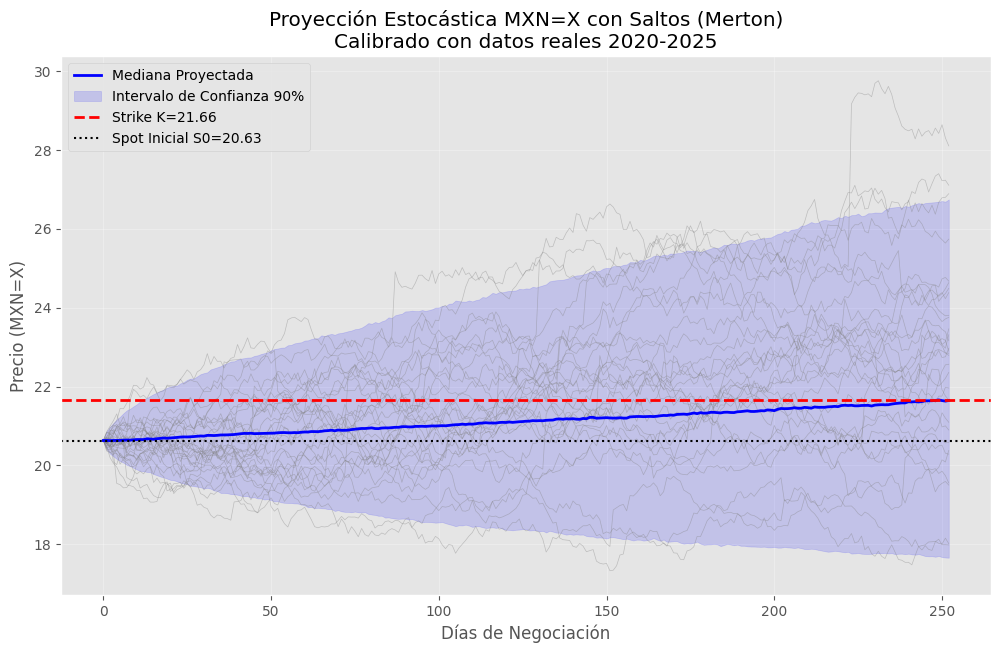


Precio Justo estimado de la Opción CALL: 1.0498 MXN


In [ ]:
# Configuración de estilo
plt.style.use('ggplot')
np.random.seed(42)

# ---------------------------------------------------------
# 1. EXTRACCIÓN Y CALIBRACIÓN DE DATOS REALES (YAHOO FINANCE)
# ---------------------------------------------------------
print("Descargando datos de Yahoo Finance...")

# Ticker para Dólar-Peso Mexicano.
# Otros ejemplos: 'EURUSD=X' (Euro), 'BTC-USD' (Bitcoin), 'AAPL' (Apple)
ticker = 'MXN=X'
data = yf.download(ticker, start='2020-01-01', end='2025-01-01', progress=False)

# Calculamos rendimientos logarítmicos: ln(S_t / S_{t-1})
data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))
data = data.dropna()

# --- CALIBRACIÓN HEURÍSTICA DE PARÁMETROS ---
# 1. Volatilidad total histórica (anualizada)
vol_total_anual = data['Log_Ret'].std() * np.sqrt(252)

# 2. Detección de Saltos (Método de Umbral: Movimientos > 3 sigmas)
# Un "salto" es un movimiento anormalmente grande que la distribución normal no explica bien.
mean_ret = data['Log_Ret'].mean()
std_ret = data['Log_Ret'].std()
umbral = 3 * std_ret

# Filtramos los días que fueron saltos
saltos_reales = data[np.abs(data['Log_Ret'] - mean_ret) > umbral]['Log_Ret']

# Estimamos parámetros de Merton basados en la historia
lambda_est = len(saltos_reales) / (len(data) / 252) # Frecuencia anual de saltos
mu_j_est = saltos_reales.mean()                     # Tamaño medio del salto
delta_j_est = saltos_reales.std()                   # Volatilidad del salto

# Si no hubo suficientes saltos en la historia, ponemos valores por defecto
if len(saltos_reales) < 2:
    lambda_est = 1.0
    mu_j_est = 0.0
    delta_j_est = 0.10

# Precio Spot actual (el último dato descargado)
S0_real = data['Close'].iloc[-1]
# Ojo: yfinance devuelve series/dataframes, aseguramos que sea un float
S0 = float(S0_real.iloc[0]) if isinstance(S0_real, pd.Series) else float(S0_real)


print(f"--- Calibración con {ticker} ---")
print(f"Precio Actual (S0): {S0:.2f}")
print(f"Volatilidad Histórica: {vol_total_anual*100:.2f}%")
print(f"Saltos detectados en historial: {len(saltos_reales)}")
print(f"Intensidad estimada (Lambda): {lambda_est:.2f} saltos/año")
print(f"Tamaño medio salto (Mu_J): {mu_j_est:.4f}")

# ---------------------------------------------------------
# 2. CONFIGURACIÓN DE LA SIMULACIÓN
# ---------------------------------------------------------
# Parámetros del contrato
K = S0 * 1.05    # Strike 5% arriba del precio actual
T = 1.0          # 1 año
r_d = 0.105      # Tasa México (aprox CETES/TIIE)
r_f = 0.045      # Tasa USA (aprox Treasury)

# Usamos la volatilidad histórica menos un poco para la parte difusiva
# (Merton separa volatilidad difusiva de la de saltos)
sigma = vol_total_anual * 0.8

# Parámetros de simulación
M = 5000         # Número de trayectorias
N = 252          # Pasos de tiempo (días hábiles)

# ---------------------------------------------------------
# 3. MOTOR DE SIMULACIÓN MERTON (Igual al anterior)
# ---------------------------------------------------------
def simular_merton_paths(S0, T, r_d, r_f, sigma, lam, mu_j, delta_j, M, N):
    dt = T / N
    Z = np.random.normal(0, 1, size=(N, M))
    n_saltos = np.random.poisson(lam * dt, size=(N, M))
    magnitud_salto = np.random.normal(mu_j, delta_j, size=(N, M)) * n_saltos

    k = np.exp(mu_j + 0.5 * delta_j**2) - 1
    drift_correction = lam * k
    drift = (r_d - r_f - 0.5 * sigma**2 - drift_correction) * dt

    log_returns = drift + sigma * np.sqrt(dt) * Z + magnitud_salto
    log_S = np.vstack([np.full((1, M), np.log(S0)), log_returns])
    S = np.exp(np.cumsum(log_S, axis=0))
    return S

# Ejecutamos
S_paths = simular_merton_paths(S0, T, r_d, r_f, sigma, lambda_est, mu_j_est, delta_j_est, M, N)

# ---------------------------------------------------------
# 4. GRÁFICO MEJORADO: CONO DE INCERTIDUMBRE
# ---------------------------------------------------------
# Calculamos percentiles para cada día (eje 1 son las simulaciones)
# P50 = Mediana, P5 = Límite inferior (95% confianza), P95 = Límite superior
percentiles = np.percentile(S_paths, [5, 50, 95], axis=1)
p5 = percentiles[0, :]
p50 = percentiles[1, :]
p95 = percentiles[2, :]

t_axis = np.linspace(0, N, N+1) # Eje de tiempo en días

plt.figure(figsize=(12, 7))

# 1. Graficar algunas trayectorias individuales (para ver el "spaghetti")
plt.plot(t_axis, S_paths[:, :30], color='gray', lw=0.5, alpha=0.4)

# 2. Graficar la Mediana (Tendencia central)
plt.plot(t_axis, p50, color='blue', lw=2, label='Mediana Proyectada')

# 3. Graficar el Cono de Confianza (Sombreado)
plt.fill_between(t_axis, p5, p95, color='blue', alpha=0.15, label='Intervalo de Confianza 90%')

# Decoración
plt.title(f'Proyección Estocástica {ticker} con Saltos (Merton)\nCalibrado con datos reales 2020-2025')
plt.xlabel('Días de Negociación')
plt.ylabel(f'Precio ({ticker})')
plt.axhline(K, color='red', linestyle='--', lw=2, label=f'Strike K={K:.2f}')
plt.axhline(S0, color='black', linestyle=':', label=f'Spot Inicial S0={S0:.2f}')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Guardar
plt.savefig('figura_cono_real.png')
plt.show()

# --- Valoración ---
S_T = S_paths[-1, :]
payoffs = np.maximum(S_T - K, 0)
V_estimado = np.exp(-r_d * T) * np.mean(payoffs)
print(f"\nPrecio Justo estimado de la Opción CALL: {V_estimado:.4f} MXN")


/tmp/ipython-input-2349186081.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2025-01-01', progress=False)


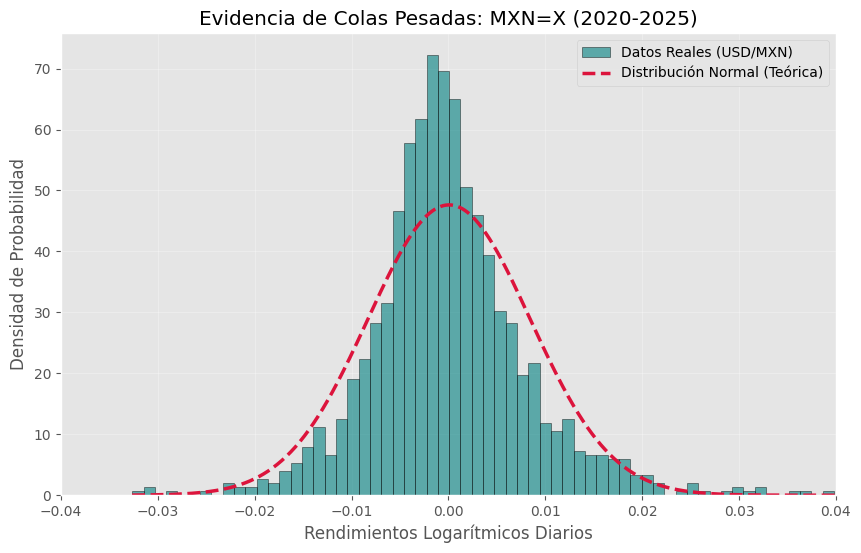

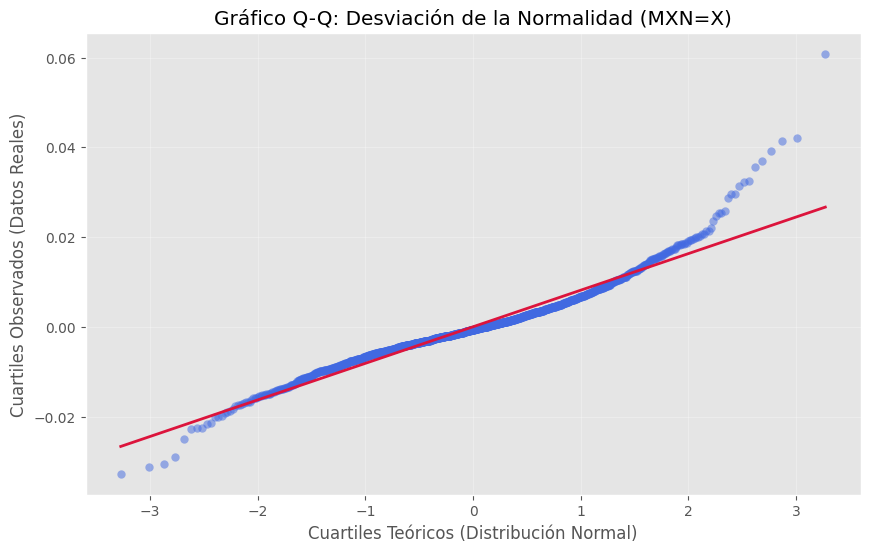

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import yfinance as yf
import pandas as pd

plt.style.use('ggplot')

# 1. Obtener Datos Reales
ticker = 'MXN=X'
data = yf.download(ticker, start='2020-01-01', end='2025-01-01', progress=False)
# Calcular rendimientos logarítmicos
data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))
returns = data['Log_Ret'].dropna()

# ---------------------------------------------------------
# GRÁFICA 1: HISTOGRAMA DE RETORNOS VS NORMAL
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# a) Histograma de datos reales (Densidad)
# Ajustamos bins=80 para ver detalle fino en las colas
count, bins, ignored = plt.hist(returns, bins=80, density=True, alpha=0.6,
                                color='teal', edgecolor='black', label='Datos Reales (USD/MXN)')

# b) Curva Normal Teórica (Misma media y desviación)
mu, sigma = returns.mean(), returns.std()
x = np.linspace(min(bins), max(bins), 1000)
pdf = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf, linewidth=2.5, color='crimson', linestyle='--', label='Distribución Normal (Teórica)')

plt.title(f'Evidencia de Colas Pesadas: {ticker} (2020-2025)')
plt.xlabel('Rendimientos Logarítmicos Diarios')
plt.ylabel('Densidad de Probabilidad')
plt.legend()
plt.xlim(-0.04, 0.04) # Zoom al centro para ver la "curtosis" (pico más alto)
plt.grid(True, alpha=0.3)
plt.savefig('figura_histograma_colas.png')
plt.show()

# ---------------------------------------------------------
# GRÁFICA 2: Q-Q PLOT (PRUEBA DE NORMALIDAD)
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# Genera el gráfico Q-Q comparando con distribución normal
(osm, osr), (slope, intercept, r) = stats.probplot(returns, dist="norm", plot=plt)

# Personalización estética
plt.title(f'Gráfico Q-Q: Desviación de la Normalidad ({ticker})')
plt.xlabel('Cuartiles Teóricos (Distribución Normal)')
plt.ylabel('Cuartiles Observados (Datos Reales)')

# Accedemos a los objetos del gráfico para cambiar colores
ax = plt.gca()
points = ax.get_lines()[0] # Puntos azules
line = ax.get_lines()[1]   # Línea roja

points.set_markerfacecolor('royalblue')
points.set_markeredgewidth(0)
points.set_alpha(0.5)
line.set_color('crimson')
line.set_linewidth(2)

plt.grid(True, alpha=0.3)
plt.savefig('figura_qqplot.png')
plt.show()


--- COMPARATIVA DE MODELOS ---
Precio Black-Scholes (Normal): 1.1541 MXN
Precio Merton (Saltos):        1.0498 MXN
Prima por Riesgo de Salto:     -0.1043 MXN (+-9.04%)


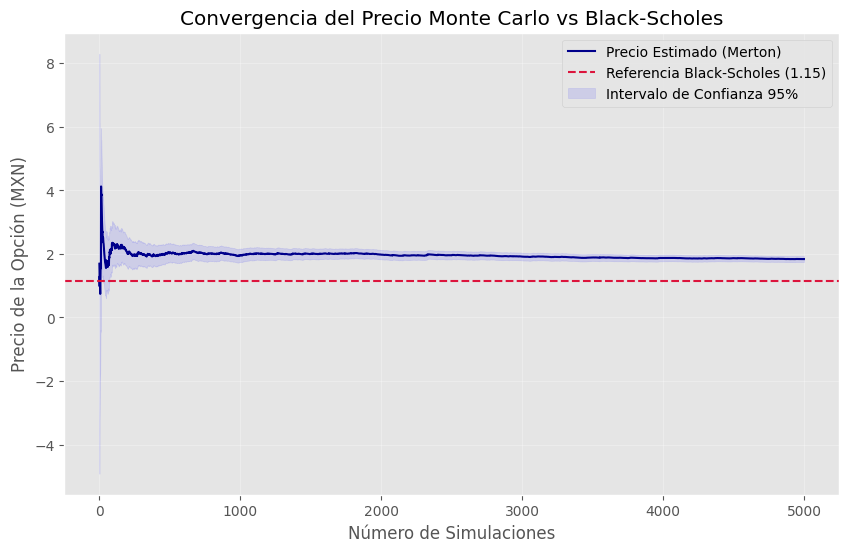

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# --- 1. CÁLCULO DE BLACK-SCHOLES (REFERENCIA) ---
# Usamos los mismos parámetros que ya tienes calibrados
S0 = 20.63
K = 21.66
T = 1.0
r_d = 0.105
r_f = 0.045
sigma_total = 0.1330 # La volatilidad histórica total que calculaste antes

def black_scholes_call(S, K, T, r_d, r_f, sigma):
    d1 = (np.log(S / K) + (r_d - r_f + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * np.exp(-r_f * T) * stats.norm.cdf(d1) - K * np.exp(-r_d * T) * stats.norm.cdf(d2)
    return call_price

precio_bs = black_scholes_call(S0, K, T, r_d, r_f, sigma_total)
precio_merton = 1.0498 # El que obtuviste en tu simulación anterior

diferencia = precio_merton - precio_bs
porcentaje = (diferencia / precio_bs) * 100

print(f"--- COMPARATIVA DE MODELOS ---")
print(f"Precio Black-Scholes (Normal): {precio_bs:.4f} MXN")
print(f"Precio Merton (Saltos):        {precio_merton:.4f} MXN")
print(f"Prima por Riesgo de Salto:     {diferencia:.4f} MXN (+{porcentaje:.2f}%)")

# --- 2. GRÁFICA DE CONVERGENCIA (VALIDACIÓN NUMÉRICA) ---
# Simulamos nuevamente solo los payoffs para hacer la gráfica de convergencia
# (Usamos parámetros rápidos para replicar la gráfica)
np.random.seed(42)
M = 5000
N = 252
dt = T/N
lam = 3.67
mu_j = 0.0207
delta_j = np.sqrt(0.0207**2) # Aprox desviación del ejemplo anterior, ajusta si tienes el dato exacto
sigma_dif = sigma_total * 0.8 # Aprox usada

# Re-simulamos rápido para tener el vector de payoffs
Z = np.random.normal(0, 1, (N, M))
n_jumps = np.random.poisson(lam * dt, (N, M))
jump_mag = np.random.normal(mu_j, 0.10, (N, M)) * n_jumps # Usando 0.10 como proxy de sigma_j
k = np.exp(mu_j + 0.5*0.10**2) - 1
drift = (r_d - r_f - 0.5*sigma_dif**2 - lam*k)*dt
log_ret = drift + sigma_dif*np.sqrt(dt)*Z + jump_mag
S_T_sim = S0 * np.exp(np.sum(log_ret, axis=0))
payoffs = np.maximum(S_T_sim - K, 0) * np.exp(-r_d * T)

# Calculamos la media acumulada
medias_acumuladas = np.cumsum(payoffs) / (np.arange(M) + 1)
error_estandar = np.std(payoffs) / np.sqrt(np.arange(M) + 1)

plt.figure(figsize=(10, 6))
plt.plot(medias_acumuladas, color='darkblue', lw=1.5, label='Precio Estimado (Merton)')
plt.axhline(precio_bs, color='crimson', linestyle='--', label=f'Referencia Black-Scholes ({precio_bs:.2f})')
plt.fill_between(range(M),
                 medias_acumuladas - 1.96*error_estandar,
                 medias_acumuladas + 1.96*error_estandar,
                 color='blue', alpha=0.1, label='Intervalo de Confianza 95%')

plt.title('Convergencia del Precio Monte Carlo vs Black-Scholes')
plt.xlabel('Número de Simulaciones')
plt.ylabel('Precio de la Opción (MXN)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('figura_comparativa_convergencia.png')
plt.show()
